In [1542]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Architecture

#### Feature engineering

In [1543]:
planning = pd.read_excel('../dataset/a6_booster_delivery_planning.xlsx')
# tracks = pd.read_excel('../dataset/ariane_tracks_booster_container_1.0.xlsx')
tracks = pd.read_csv('../dataset/containers.csv')

tracks['Entry'] = pd.to_datetime(tracks['Entry'], format='%Y-%m-%d')
tracks['Exit'] = pd.to_datetime(tracks['Exit'], format='%Y-%m-%d')

sorted_tracks = tracks.sort_values(by=['Container','Entry'])

sorted_tracks = sorted_tracks.reset_index(drop=True)
sorted_tracks['StayDays'] = sorted_tracks['Exit'] - sorted_tracks['Entry']

<Axes: xlabel='Month'>

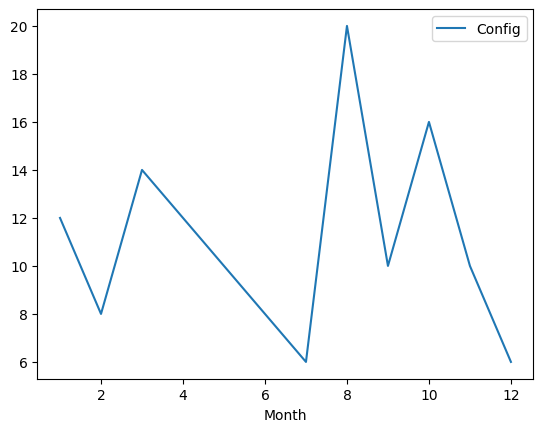

In [1544]:
planning['Month'] = planning['Date'].dt.month
planning[['Month', 'Config']].groupby('Month').sum().plot()

In [1545]:
def stay_prep(sample):

    sample = sample.reset_index(drop=True)

    sample['ZonePos'] = [ord(x) - 64 for x in sample['Zone']]
    sample['ZonePosPrev'] = [np.nan] + [ord(x) - 64 for x in sample['Zone']][:-1]
    sample['ZoneDelta'] = sample['ZonePos'] - sample['ZonePosPrev']
    sample.loc[sample['ZoneDelta'] < 0, 'Zone'] = sample[sample['ZoneDelta'] < 0]['Zone'].astype(str) + '1'

    df_staying = pd.get_dummies(sample['Zone'])
    df_staying['Container'] = sample['Container']
    df_staying['Entry'] = sample['Entry']
    df_staying['Exit'] = sample['Exit']
    df_staying['Days'] = sample['StayDays']

    return df_staying

def move_prep(sample):

    sample = sample.reset_index(drop=True)

    sample['Transition'] = sample['Zone'].shift(1).str.cat(sample['Zone'])
    df_moving = pd.get_dummies(sample['Transition'])

    exit_shift = sample['Exit'][:-1].reset_index(drop=True)
    exit_shift.index = np.arange(1, len(exit_shift) + 1)
    df_moving.loc[1:, 'Entry'] = exit_shift
    df_moving.loc[1:,'Exit'] = sample[1:]['Entry']
    
    shift = sample[1:]['Entry'].reset_index(drop=True) - sample['Exit'][:-1]
    shift.index = np.arange(1, len(shift) + 1)
    sample.loc[1:, 'TransitionTime'] = shift
    df_moving['Container'] = sample['Container']
    df_moving['Days'] = sample['TransitionTime']
    print('Length before:', len(df_moving))
    df_moving = df_moving.dropna(subset='Days')
    print('Length after:', len(df_moving))

    return df_moving
        

In [1546]:
def data_prep(sorted_tracks):
    out = None

    for container in sorted_tracks['Container'].unique():
        print('Doing ', container)
        cont_df = sorted_tracks[sorted_tracks['Container'] == container]
        moving = move_prep(cont_df)
        staying = stay_prep(cont_df)

        if out is None:
            out = pd.concat([moving, staying])
        else:
            out = pd.concat([out, moving, staying])

    return out

In [1547]:
out = data_prep(sorted_tracks)

Doing  SN1
Length before: 40
Length after: 39
Doing  SN2
Length before: 40
Length after: 39
Doing  SN3
Length before: 40
Length after: 39
Doing  SN4
Length before: 40
Length after: 39
Doing  SN5
Length before: 17
Length after: 16
Doing  SN6
Length before: 56
Length after: 55
Doing  SN7
Length before: 72
Length after: 71
Doing  SN8
Length before: 64
Length after: 63


#### CA is above because of the errors in the data; should add a preprocessing

In [1548]:
# so far - just drop it
# out = out.drop(columns=['CA'])
# set NaN to 0:
out = out.fillna(False)

In [1549]:
out

,AB,BA,BC,CB,CD,DC,DE,ED,Entry,Exit,...,Days,A,A1,B,B1,C,C1,D,D1,E
1,True,False,False,False,False,False,False,False,2021-09-30,2021-09-30,...,0 days,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,2021-10-05,2021-10-05,...,0 days,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,2021-10-06,2021-10-17,...,11 days,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,2021-10-19,2021-10-19,...,0 days,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,True,2021-11-03,2021-11-03,...,0 days,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,False,False,False,False,False,False,False,False,2024-03-21,2024-03-23,...,2 days,False,False,False,False,False,False,True,False,False
60,False,False,False,False,False,False,False,False,2024-03-23,2024-04-07,...,15 days,False,False,False,False,False,False,False,False,True
61,False,False,False,False,False,False,False,False,2024-04-07,2024-04-09,...,2 days,False,False,False,False,False,False,False,True,False
62,False,False,False,False,False,False,False,False,2024-04-19,2024-04-20,...,1 days,False,False,False,False,False,True,False,False,False


In [1550]:
out[['A', 'AB', 'B', 'B1', 'BC', 'C', 'C1', 'CD', 'D', 'D1', 'DE', 'E', 'ED', 'DC', 'CB', 'BA']] = out[['A', 'AB', 'B', 'B1', 'BC', 'C', 'C1', 'CD', 'D', 'D1', 'DE', 'E', 'ED', 'DC', 'CB', 'BA']]*1
out = out[['Container', 'A', 'AB', 'B', 'B1', 'BC', 'C', 'C1', 'CD', 'D', 'D1', 'DE', 'E', 'ED', 'DC', 'CB', 'BA', 'Entry', 'Exit', 'Days']]

In [1551]:
out

,Container,A,AB,B,B1,BC,C,C1,CD,D,D1,DE,E,ED,DC,CB,BA,Entry,Exit,Days
1,SN1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-09-30,2021-09-30,0 days
2,SN1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2021-10-05,2021-10-05,0 days
3,SN1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2021-10-06,2021-10-17,11 days
4,SN1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2021-10-19,2021-10-19,0 days
5,SN1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2021-11-03,2021-11-03,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,SN8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2024-03-21,2024-03-23,2 days
60,SN8,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2024-03-23,2024-04-07,15 days
61,SN8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2024-04-07,2024-04-09,2 days
62,SN8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2024-04-19,2024-04-20,1 days


### TODO: Add sanity check for the data

In [1552]:
summed_out = out.drop(columns=['Container']).groupby(['Entry', 'Exit'], as_index=False).sum()

In [1553]:
summed_out

,Entry,Exit,A,AB,B,B1,BC,C,C1,CD,D,D1,DE,E,ED,DC,CB,BA,Days
0,2020-12-09,2020-12-24,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30 days
1,2020-12-24,2020-12-24,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 days
2,2020-12-24,2020-12-29,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,10 days
3,2020-12-29,2020-12-29,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0 days
4,2020-12-29,2020-12-30,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,2024-04-07,2024-04-09,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,8 days
262,2024-04-09,2024-04-19,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,40 days
263,2024-04-19,2024-04-20,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,4 days
264,2024-04-20,2024-04-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0 days


#### removing the inverted combinations (BA, CB, etc.)

In [1554]:
inverted = [['BA', 'AB'], ['CB', 'BC'], ['DC', 'CD'], ['ED', 'DE']]

summed_out['Inverted'] = 0
for inv, true in inverted:
    mask = summed_out[inv] != 0
    print(len(mask))
    summed_out.loc[mask, true] = summed_out[mask][inv]
    summed_out.loc[mask, 'Inverted'] = 1

summed_out_inverted = summed_out.drop(columns=['BA', 'CB', 'DC', 'ED'])


266
266
266
266


In [1555]:
summed_out_inverted = summed_out_inverted.rename(columns={'E1': 'E'})

for inv, true in [['B1', 'B'], ['C1', 'C'], ['D1', 'D']]:
    mask = summed_out_inverted[inv] != 0
    print(len(mask))
    summed_out_inverted.loc[mask, true] = summed_out_inverted[mask][inv]
    summed_out_inverted.loc[mask, 'Inverted'] = 1

summed_out_inverted = summed_out_inverted.drop(columns=['B1', 'C1', 'D1'])

266
266
266


In [1556]:
summed_out_inverted

,Entry,Exit,A,AB,B,BC,C,CD,D,DE,E,Days,Inverted
0,2020-12-09,2020-12-24,2,0,0,0,0,0,0,0,0,30 days,0
1,2020-12-24,2020-12-24,0,2,0,0,0,0,0,0,0,0 days,0
2,2020-12-24,2020-12-29,0,0,2,0,0,0,0,0,0,10 days,0
3,2020-12-29,2020-12-29,0,0,0,2,0,0,0,0,0,0 days,0
4,2020-12-29,2020-12-30,0,0,0,0,2,0,0,0,0,2 days,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,2024-04-07,2024-04-09,0,0,0,0,0,0,4,0,0,8 days,1
262,2024-04-09,2024-04-19,0,0,0,0,0,4,0,0,0,40 days,1
263,2024-04-19,2024-04-20,0,0,0,0,4,0,0,0,0,4 days,1
264,2024-04-20,2024-04-20,0,0,0,4,0,0,0,0,0,0 days,1


In [1557]:
# since we summed the number of days, we need to divide it by the number of occurences
summed_out_inverted['Days'] = summed_out_inverted['Days'].dt.days
summed_out_inverted[['A', 'AB', 'B', 'BC', 'C', 'CD', 'D', 'DE', 'E']] = summed_out_inverted[['A', 'AB', 'B', 'BC', 'C', 'CD', 'D', 'DE', 'E']].astype(int)
summed_out_inverted['Days'] = summed_out_inverted['Days'] / summed_out_inverted[['A', 'AB', 'B', 'BC', 'C', 'CD', 'D', 'DE', 'E']].sum(axis=1)

In [1558]:
# something weird is going on 
summed_out_inverted = summed_out_inverted[summed_out_inverted['Days'] != np.inf]
summed_out_inverted['Days'] = summed_out_inverted['Days'].astype(int)

/var/folders/g0/m852bq5j7gd84y0trm3pm2yr0000gn/T/ipykernel_69811/4123594864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summed_out_inverted['Days'] = summed_out_inverted['Days'].astype(int)


In [1559]:
summed_out_inverted.head(60)

,Entry,Exit,A,AB,B,BC,C,CD,D,DE,E,Days,Inverted
0,2020-12-09,2020-12-24,2,0,0,0,0,0,0,0,0,15,0
1,2020-12-24,2020-12-24,0,2,0,0,0,0,0,0,0,0,0
2,2020-12-24,2020-12-29,0,0,2,0,0,0,0,0,0,5,0
3,2020-12-29,2020-12-29,0,0,0,2,0,0,0,0,0,0,0
4,2020-12-29,2020-12-30,0,0,0,0,2,0,0,0,0,1,0
5,2020-12-30,2021-01-10,0,0,0,0,0,2,0,0,0,11,0
6,2021-01-10,2021-01-12,0,0,0,0,0,0,2,0,0,2,0
7,2021-01-12,2021-01-12,0,0,0,0,0,0,0,2,0,0,0
8,2021-01-12,2021-01-27,0,0,0,0,0,0,0,0,2,15,0
9,2021-01-27,2021-01-27,0,0,0,0,0,0,0,2,0,0,1


In [1560]:
# summed_out_inverted.to_csv('cleaned_tracks.csv', index=False)

In [1561]:
# summed_out_inverted = pd.read_csv('../dataset/cleaned_tracks.csv')

### Adding features

#### Supplier performance

In [1562]:
time_dict = {}
stages = ['A', 'AB', 'B', 'BC', 'C', 'CD', 'D', 'DE', 'E']
for stage in stages:
    time_dict[stage] = [summed_out_inverted[(summed_out_inverted[stage] != 0) & (summed_out_inverted['Inverted'] == 0)]['Days'].to_list(),
                        summed_out_inverted[(summed_out_inverted[stage] != 0) & (summed_out_inverted['Inverted'] == 1)]['Days'].to_list()]

In [1563]:
mean_dict = {}
std_dict = {}
for key in time_dict:
    print(key)
    print('Normal:', np.mean(time_dict[key][0]))
    print('Inverted:', np.mean(time_dict[key][1]))
    print('Normal:', np.std(time_dict[key][0]))
    print('Inverted:', np.std(time_dict[key][1]))
    mean_dict[key] = [np.mean(time_dict[key][0]), np.mean(time_dict[key][1])]
    std_dict[key] = [np.std(time_dict[key][0]), np.std(time_dict[key][1])]
    

A
Normal: 24.0
Inverted: nan
Normal: 7.3484692283495345
Inverted: nan
AB
Normal: 0.0
Inverted: 119.89285714285714
Normal: 0.0
Inverted: 100.92866621166311
B
Normal: 5.0
Inverted: 5.0
Normal: 0.0
Inverted: 0.0
BC
Normal: 0.0
Inverted: 0.0
Normal: 0.0
Inverted: 0.0
C
Normal: 1.0
Inverted: 1.0
Normal: 0.0
Inverted: 0.0
CD
Normal: 10.375
Inverted: 10.5
Normal: 0.5994789404140899
Inverted: 1.0606601717798212
D
Normal: 2.0
Inverted: 2.0
Normal: 0.0
Inverted: 0.0
DE
Normal: 0.0
Inverted: 0.0
Normal: 0.0
Inverted: 0.0
E
Normal: 15.9375
Inverted: nan
Normal: 3.6309218870694533
Inverted: nan


/Users/remi/anaconda3/envs/i2dl/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/remi/anaconda3/envs/i2dl/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/remi/anaconda3/envs/i2dl/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/remi/anaconda3/envs/i2dl/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/remi/anaconda3/envs/i2dl/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [1564]:
stages = ['A', 'AB', 'B', 'BC', 'C', 'CD', 'D', 'DE', 'E']
for stage in stages:
    for i in [0,1]:
        mask = (summed_out_inverted[stage] != 0) & (summed_out_inverted['Inverted'] == i)
        summed_out_inverted.loc[mask, 'PerfMean'] = mean_dict[stage][i]
        summed_out_inverted.loc[mask, 'PerfStd'] = std_dict[stage][i]

/var/folders/g0/m852bq5j7gd84y0trm3pm2yr0000gn/T/ipykernel_69811/2314864211.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summed_out_inverted.loc[mask, 'PerfMean'] = mean_dict[stage][i]
/var/folders/g0/m852bq5j7gd84y0trm3pm2yr0000gn/T/ipykernel_69811/2314864211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summed_out_inverted.loc[mask, 'PerfStd'] = std_dict[stage][i]


### Season busy-ness

<Axes: xlabel='Month'>

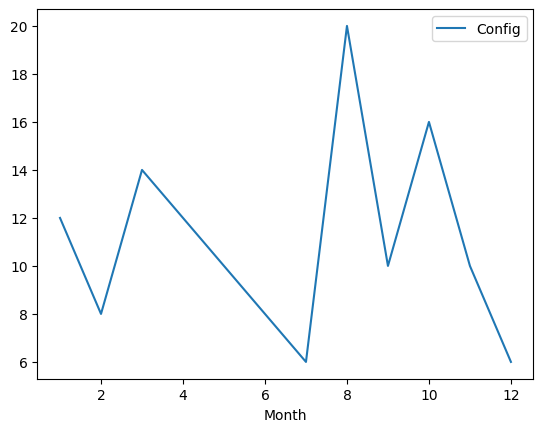

In [1565]:
planning['Month'] = planning['Date'].dt.month
planning[['Month', 'Config']].groupby('Month').sum().plot()

In [1566]:
montly_load = planning.groupby('Month', as_index=False).sum(['Config'])

In [1567]:
first_split = np.quantile(montly_load['Config'].to_list(), 0.33)
second_split = np.quantile(montly_load['Config'].to_list(), 0.66)

In [1568]:
montly_load.loc[(montly_load['Config'] <  first_split), 'LoadBucket'] = 0
montly_load.loc[(montly_load['Config'] >=  first_split) & (montly_load['Config'] <  second_split), 'LoadBucket'] = 1
montly_load.loc[(montly_load['Config'] >=  second_split), 'LoadBucket'] = 2

In [1569]:
summed_out_inverted['Entry'] = pd.to_datetime(summed_out_inverted['Entry'], format='%Y-%m-%d')
summed_out_inverted['Exit'] = pd.to_datetime(summed_out_inverted['Exit'], format='%Y-%m-%d')
summed_out_inverted['EntryMonth'] = summed_out_inverted['Entry'].dt.month
summed_out_inverted['ExitMonth'] = summed_out_inverted['Exit'].dt.month

/var/folders/g0/m852bq5j7gd84y0trm3pm2yr0000gn/T/ipykernel_69811/3699231480.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summed_out_inverted['Entry'] = pd.to_datetime(summed_out_inverted['Entry'], format='%Y-%m-%d')
/var/folders/g0/m852bq5j7gd84y0trm3pm2yr0000gn/T/ipykernel_69811/3699231480.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summed_out_inverted['Exit'] = pd.to_datetime(summed_out_inverted['Exit'], format='%Y-%m-%d')
/var/folders/g0/m852bq5j7gd84y0trm3pm2yr0000gn/T/ipykernel_69811/369

In [1570]:
summed_out_inverted = pd.merge(summed_out_inverted, montly_load[['Month', 'LoadBucket']], how='left', left_on='EntryMonth', right_on='Month').drop(columns=['Month']).rename(columns={'LoadBucket': 'EntryLoad'})
summed_out_inverted = pd.merge(summed_out_inverted, montly_load[['Month', 'LoadBucket']], how='left', left_on='ExitMonth', right_on='Month').drop(columns=['Month']).rename(columns={'LoadBucket': 'ExitLoad'})

In [1571]:
# first we have to deal with the NaNs
# assume that the absent months have the load of 0
summed_out_inverted['EntryLoad'] = summed_out_inverted['EntryLoad'].fillna(0)
summed_out_inverted['ExitLoad'] = summed_out_inverted['ExitLoad'].fillna(0)
summed_out_inverted['EntryLoad'] = summed_out_inverted['EntryLoad'].astype(int)
summed_out_inverted['ExitLoad'] = summed_out_inverted['ExitLoad'].astype(int)

### Adding demand in each month

In [1572]:
summed_out_inverted['EntryYear'] = summed_out_inverted['Entry'].dt.year
summed_out_inverted['ExitYear'] = summed_out_inverted['Exit'].dt.year

In [1573]:
planning['Year'] = planning['Date'].dt.year
unique_month_plan = planning.groupby(['Year', 'Month'], as_index=False)['Config'].sum()

In [1574]:
summed_out_inverted = pd.merge(summed_out_inverted, unique_month_plan[['Config', 'Month', 'Year']], how='left', left_on=['EntryYear', 'EntryMonth'], right_on=['Year', 'Month']).rename(columns={'Config': 'EntryDemand'}).drop(columns=['Month', 'Year'])
summed_out_inverted = pd.merge(summed_out_inverted, unique_month_plan[['Config', 'Month', 'Year']], how='left', left_on=['ExitYear', 'ExitMonth'], right_on=['Year', 'Month']).rename(columns={'Config': 'ExitDemand'}).drop(columns=['Month', 'Year'])

In [1575]:
# fill the nans of demand with 0
summed_out_inverted['EntryDemand'] = summed_out_inverted['EntryDemand'].fillna(0)
summed_out_inverted['ExitDemand'] = summed_out_inverted['ExitDemand'].fillna(0)
# and convert to int
summed_out_inverted['EntryDemand'] = summed_out_inverted['EntryDemand'].astype(int)
summed_out_inverted['ExitDemand'] = summed_out_inverted['ExitDemand'].astype(int)

In [1576]:
summed_out_inverted = summed_out_inverted.drop(columns=['EntryYear', 'ExitYear', 'EntryMonth', 'ExitMonth']) 

### Extracting the distances: for transition it is a distance between points

Zone A : Bordeaux

AB = 9.70 km

Zone B : Blanquefort

BC = 9.42 km

Zone C : harbor of Bordeaux

CD = 6698.14 km

Zone D : Harbor of Kourou

DE = 15.06 km

Zone E : Centre Spatial Guyanais

In [1577]:
summed_out_inverted.loc[summed_out_inverted['AB'] != 0, 'Distance'] = 9.70
summed_out_inverted.loc[summed_out_inverted['BC'] != 0, 'Distance'] = 9.42
summed_out_inverted.loc[summed_out_inverted['CD'] != 0, 'Distance'] = 6698.14
summed_out_inverted.loc[summed_out_inverted['DE'] != 0, 'Distance'] = 15.06

In [1578]:
# fill the NA distances with zeroes
summed_out_inverted['Distance'] = summed_out_inverted['Distance'].fillna(0)

In [1579]:
# summed_out_inverted.to_csv('interm_tracks_ver1.csv', index=False)
# summed_out_inverted = pd.read_csv('../dataset/interm_tracks_ver1.csv')

### Changing the format to suit best the single model for all stages

In [1580]:
foo = summed_out_inverted.set_index(['Entry', 'Exit'])
foo = foo[['A', 'AB', 'B', 'BC', 'C', 'CD', 'D', 'DE', 'E']][foo > 0].stack().reset_index().drop(0, axis=1).rename(columns={'level_2': 'Stage'})
foo = foo.rename(columns={'level_2': 'Stage'})
foo['Stage'] = foo['Stage'].replace({'A': 0, 'AB': 1, 'B': 2, 'BC': 3, 'C': 4, 'CD': 5, 'D': 6, 'DE': 7, 'E': 8})

In [1581]:
summed_out_inverted['ContainerQuantity'] = summed_out_inverted[['A', 'AB', 'B', 'BC', 'C', 'CD', 'D', 'DE', 'E']].sum(axis=1)
summed_out_inverted = summed_out_inverted.drop(columns=['A', 'AB', 'B', 'BC', 'C', 'CD', 'D', 'DE', 'E'])

In [1582]:
# not sure why we have NaNs here
clean_data = pd.concat([summed_out_inverted.drop(columns=['Entry', 'Exit']), foo], axis=1).dropna()

In [1583]:
clean_data[['Days', 'EntryLoad', 'ExitLoad', 'EntryDemand', 'ExitDemand', 'Stage', 'ContainerQuantity']] = clean_data[['Days', 'EntryLoad', 'ExitLoad', 'EntryDemand', 'ExitDemand', 'Stage', 'ContainerQuantity']].astype(int)

In [1584]:
clean_data.to_csv('final_tracks_ver1.csv', index=False)

In [1585]:
clean_data

,Days,Inverted,PerfMean,PerfStd,EntryLoad,ExitLoad,EntryDemand,ExitDemand,Distance,ContainerQuantity,Entry,Exit,Stage
0,15,0.0,24.0,7.348469,0,0,0,0,0.00,2,2020-12-09,2020-12-24,0
1,0,0.0,0.0,0.000000,0,0,0,0,9.70,2,2020-12-24,2020-12-24,1
2,5,0.0,5.0,0.000000,0,0,0,0,0.00,2,2020-12-24,2020-12-29,2
3,0,0.0,0.0,0.000000,0,0,0,0,9.42,2,2020-12-29,2020-12-29,3
4,1,0.0,1.0,0.000000,0,0,0,0,0.00,2,2020-12-29,2020-12-30,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2,1.0,2.0,0.000000,0,0,0,0,0.00,4,2024-04-07,2024-04-07,7
251,10,1.0,10.5,1.060660,0,0,0,0,6698.14,4,2024-04-07,2024-04-09,6
252,1,1.0,1.0,0.000000,0,0,0,0,0.00,4,2024-04-09,2024-04-19,5
253,0,1.0,0.0,0.000000,0,0,0,0,9.42,4,2024-04-19,2024-04-20,4
